In [26]:
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.cluster import DBSCAN
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load sample M&A transaction data

directory = "C:/Users/**/Downloads"
tran_file = glob(os.path.join(directory, 'ma*.csv'))
df = pd.read_csv(tran_file[0])
df.head()


,deal_id,acquirer,target,industry,deal_value,revenue_target,ebitda_target,p/e_ratio,date
0,1,Company_D,Target_4,Energy,2165.174789,322.277474,46.637124,16.953480,2015-01-04
1,2,Company_E,Target_1,Energy,529.113499,240.626861,40.558188,8.367639,2015-01-11
2,3,Company_C,Target_5,Energy,661.044762,243.063686,10.414004,20.236589,2015-01-18
3,4,Company_E,Target_3,Energy,346.022705,285.800587,64.958205,20.847950,2015-01-25
4,5,Company_E,Target_3,Retail,519.945451,170.803782,28.545139,13.853046,2015-02-01


In [4]:
df.shape

(500, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   deal_id         500 non-null    int64  
 1   acquirer        500 non-null    object 
 2   target          500 non-null    object 
 3   industry        500 non-null    object 
 4   deal_value      500 non-null    float64
 5   revenue_target  500 non-null    float64
 6   ebitda_target   500 non-null    float64
 7   p/e_ratio       500 non-null    float64
 8   date            500 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 35.3+ KB


In [6]:
df.describe()

,deal_id,deal_value,revenue_target,ebitda_target,p/e_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,540.907800,204.799705,50.010863,15.168208
std,144.481833,288.530319,77.811949,19.389834,4.883689
min,1.000000,65.561693,20.000000,5.000000,5.000000
25%,125.750000,407.600864,151.710837,37.009285,11.864238
50%,250.500000,512.034841,201.585733,50.138630,14.863472
75%,375.250000,614.485350,258.040437,63.320426,18.174656
max,500.000000,3648.063124,455.448605,112.754971,34.631189


In [7]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [8]:
# Compute Z-score within each industry
df['z_score'] = df.groupby('industry')['deal_value'].transform(zscore)

In [9]:
# Identify outliers (Z-score > 3 or < -3)
outliers = df[np.abs(df['z_score']) > 3]
print("Outlier Transactions:")
print(outliers[['deal_id', 'acquirer', 'target', 'deal_value', 'industry', 'z_score']])

Outlier Transactions:
     deal_id   acquirer    target   deal_value    industry   z_score
0          1  Company_D  Target_4  2165.174789      Energy  3.727156
32        33  Company_D  Target_2  1855.258365        Tech  6.006860
83        84  Company_E  Target_1  2554.780210  Healthcare  7.804190
109      110  Company_C  Target_1  1554.014097     Finance  5.801625
169      170  Company_D  Target_1  2143.273495      Retail  4.914408
349      350  Company_E  Target_3  1457.655415        Tech  4.176560
412      413  Company_E  Target_3  3648.063124      Energy  7.183356
435      436  Company_D  Target_1  3069.366370      Retail  7.742422


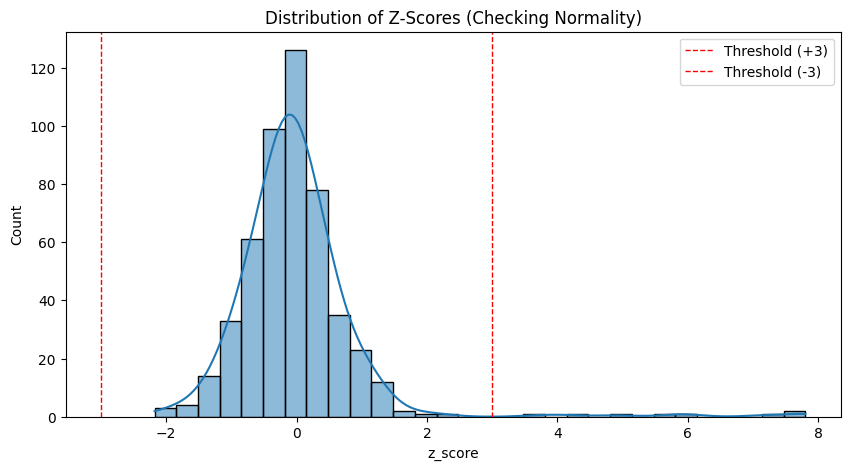

In [10]:
# Plot histogram of Z-scores
plt.figure(figsize=(10, 5))
sns.histplot(df['z_score'], bins=30, kde=True)
plt.axvline(3, color='r', linestyle='dashed', linewidth=1, label='Threshold (+3)')
plt.axvline(-3, color='r', linestyle='dashed', linewidth=1, label='Threshold (-3)')
plt.title("Distribution of Z-Scores (Checking Normality)")
plt.legend()
plt.show()

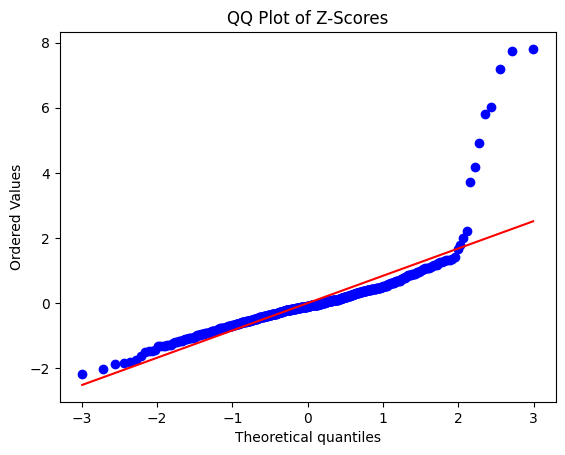

In [11]:
# QQ Plot (Quantile-Quantile Plot)
stats.probplot(df['z_score'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot of Z-Scores")
plt.show()

In [12]:
# Clustering using DBSCAN for anomaly detection
scaler = StandardScaler()
df[['deal_value_scaled', 'p/e_ratio_scaled']] = scaler.fit_transform(df[['deal_value', 'p/e_ratio']])
clustering = DBSCAN(eps=0.5, min_samples=10).fit(df[['deal_value_scaled', 'p/e_ratio_scaled']])
df['cluster'] = clustering.labels_

In [13]:
print(df['cluster'].value_counts())  # How many in each cluster
print(df[df['cluster'] == -1])  # View outliers

cluster
 0    483
-1     17
Name: count, dtype: int64
     deal_id   acquirer    target    industry   deal_value  revenue_target  \
0          1  Company_D  Target_4      Energy  2165.174789      322.277474   
32        33  Company_D  Target_2        Tech  1855.258365      224.706641   
83        84  Company_E  Target_1  Healthcare  2554.780210      155.905143   
88        89  Company_D  Target_4      Energy   634.278983      255.710996   
103      104  Company_B  Target_4     Finance   413.944999      246.567816   
109      110  Company_C  Target_1     Finance  1554.014097      323.459482   
147      148  Company_C  Target_5      Energy  1328.198063      177.493795   
156      157  Company_D  Target_1        Tech   649.440023      237.314399   
169      170  Company_D  Target_1      Retail  2143.273495      170.637773   
183      184  Company_B  Target_2  Healthcare    65.561693      309.990114   
231      232  Company_A  Target_5  Healthcare  1118.867393      407.165091   
242      2

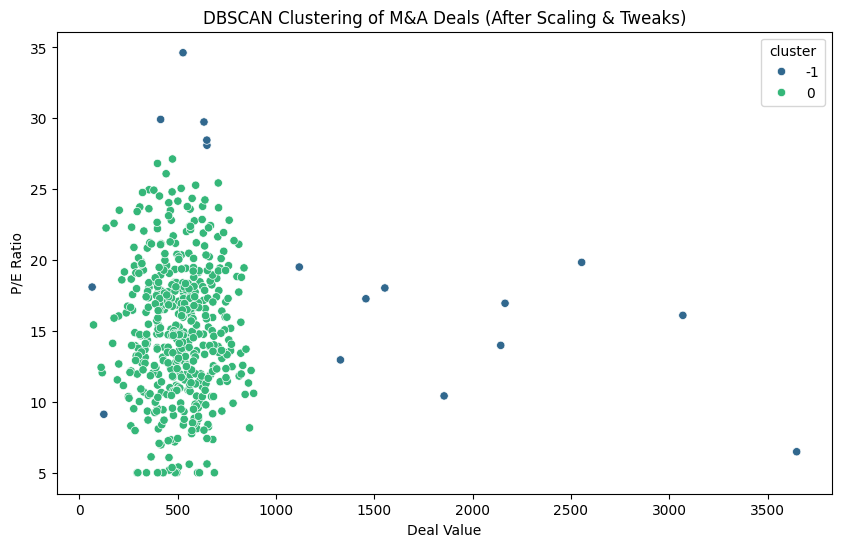

In [14]:
# Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='deal_value', y='p/e_ratio', hue=df['cluster'].astype(str), palette='viridis')
plt.title("DBSCAN Clustering of M&A Deals (After Scaling & Tweaks)")
plt.xlabel("Deal Value")
plt.ylabel("P/E Ratio")
plt.show()


In [15]:
dbscan_outliers = df[df['cluster'] == -1]
print(dbscan_outliers[['deal_id', 'acquirer', 'target', 'deal_value', 'p/e_ratio', 'cluster']])

     deal_id   acquirer    target   deal_value  p/e_ratio  cluster
0          1  Company_D  Target_4  2165.174789  16.953480       -1
32        33  Company_D  Target_2  1855.258365  10.419040       -1
83        84  Company_E  Target_1  2554.780210  19.840923       -1
88        89  Company_D  Target_4   634.278983  29.745472       -1
103      104  Company_B  Target_4   413.944999  29.926295       -1
109      110  Company_C  Target_1  1554.014097  18.034253       -1
147      148  Company_C  Target_5  1328.198063  12.959496       -1
156      157  Company_D  Target_1   649.440023  28.103965       -1
169      170  Company_D  Target_1  2143.273495  13.985097       -1
183      184  Company_B  Target_2    65.561693  18.098557       -1
231      232  Company_A  Target_5  1118.867393  19.511386       -1
242      243  Company_A  Target_2   125.089143   9.122027       -1
349      350  Company_E  Target_3  1457.655415  17.273705       -1
383      384  Company_D  Target_3   648.806352  28.465168     

In [16]:
# Industry-wise trend analysis
df['year'] = df['date'].dt.year
industry_trends = df.groupby(['industry', 'year'])['deal_value'].mean().reset_index()

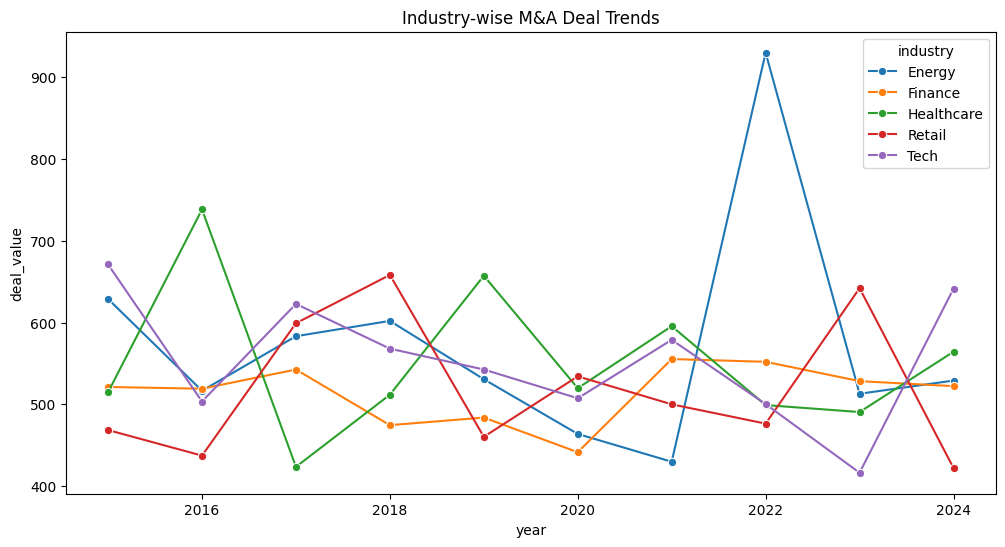

In [17]:
# Plot Industry-wise trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=industry_trends, x='year', y='deal_value', hue='industry', marker='o')
plt.title("Industry-wise M&A Deal Trends")
plt.show()

In [25]:
# Forecasting future deal values using ARIMA
arima_data = df.groupby('year')['deal_value'].mean()
arima_data.index = pd.to_datetime(arima_data.index, format='%Y')


In [27]:
# Fit ARIMA with a simpler model (avoid convergence issues)
model = ARIMA(arima_data, order=(1,1,1))
model_fit = model.fit()


In [23]:
# Forecasting for the next 5 years
future_years = pd.date_range(start=arima_data.index[-1] + pd.DateOffset(years=1), periods=5, freq='YE')
forecast = model_fit.forecast(steps=5)

In [ ]:
# Print predictions with proper index
forecast_series = pd.Series(forecast.values, index=future_years)
print("Future M&A Deal Value Predictions:")
print(forecast_series)

Future M&A Deal Value Predictions:
2025-12-31    537.542940
2026-12-31    534.732082
2027-12-31    535.522656
2028-12-31    535.300301
2029-12-31    535.362840
Freq: YE-DEC, dtype: float64


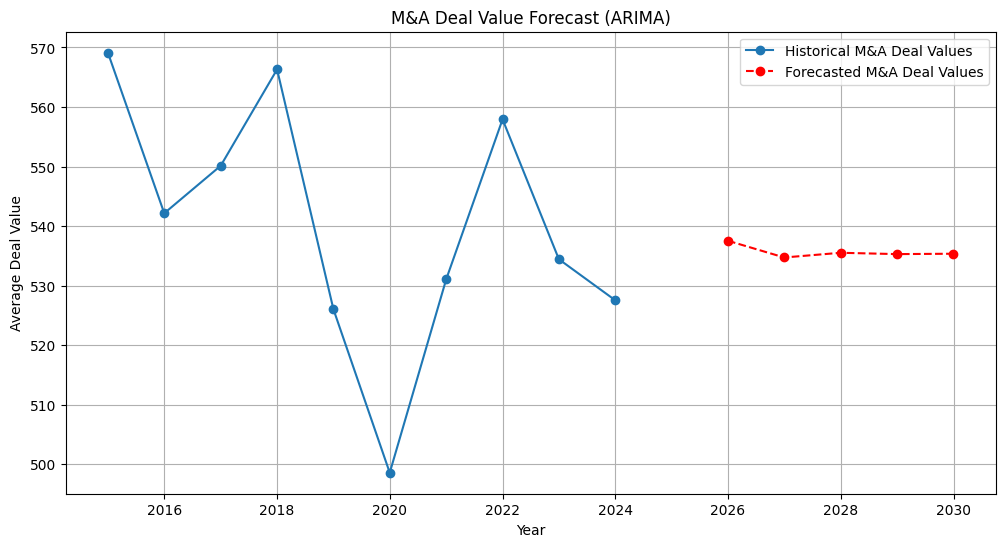

In [ ]:
# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(arima_data, label="Historical M&A Deal Values", marker="o")
plt.plot(forecast_series, label="Forecasted M&A Deal Values", linestyle="dashed", marker="o", color="red")

# Formatting
plt.title("M&A Deal Value Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("Average Deal Value")
plt.legend()
plt.grid(True)
plt.show()